In [1]:
from kitti_detection import config
from kitti_detection.dataset import DataSample, class_names, load_train_val_test_dataset
from kitti_detection.utils import display_samples_h
from kitti_detection import box_utils

import torch
import torchvision
from torch import nn, optim, Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.tv_tensors import BoundingBoxes

from scipy.optimize import linear_sum_assignment

In [2]:
IMG_WIDTH, IMG_HEIGHT = 370, 370

box_normalize_tensor = torch.tensor([1 / IMG_WIDTH, 1 / IMG_HEIGHT, 1 / IMG_WIDTH, 1 / IMG_HEIGHT])
box_inv_normalize_tensor = torch.tensor([IMG_WIDTH, IMG_HEIGHT, IMG_WIDTH, IMG_HEIGHT])

In [3]:
class NormalizeBoxes(v2.Transform):
    def forward(self, img, target):
        target['boxes'] *= box_normalize_tensor
        return img, target

In [4]:
base_transform = v2.Compose([
    v2.RandomCrop(size=(370, 370)),
    v2.SanitizeBoundingBoxes(),
    v2.ConvertBoundingBoxFormat(format='cxcywh'),
])

In [5]:
preprocess_img = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
preprocess_label = NormalizeBoxes()

In [7]:
transforms = v2.Compose([
    base_transform,
    preprocess_img,
    preprocess_label,
])

In [8]:
train_dataset, valid_dataset, test_dataset = load_train_val_test_dataset()

train_dataset.transform = transforms
valid_dataset.transform = transforms

In [9]:
classes = class_names[:-1]
n_classes = len(classes)

class_counts = {
    'Car': 8297, 
    'Van': 881, 
    'Truck': 343, 
    'Pedestrian': 1034, 
    'Person_sitting': 44, 
    'Cyclist': 374, 
    'Tram': 140, 
    'Misc': 251, 
    'DontCare': 0
}
class_weights = [ 1 / class_counts[c] for c in classes]

print(class_weights)


[0.0001205254911413764, 0.0011350737797956867, 0.0029154518950437317, 0.0009671179883945841, 0.022727272727272728, 0.00267379679144385, 0.007142857142857143, 0.00398406374501992]


In [10]:
def get_1d_pos_encoding(l, dim):
    return torch.cat([
        torch.stack([
            torch.linspace(0, 10000**(2*i/dim), steps=l).sin(),
            torch.linspace(0, 10000**(2*i/dim), steps=l).cos()
        ], dim=1)
        for i in range(dim // 2)
    ], dim=1)

def create_pos_encoding(h, w, dim):
    col_embed = get_1d_pos_encoding(w, dim // 2).repeat(h, 1, 1)
    row_embed = get_1d_pos_encoding(h, dim // 2).unsqueeze(1).repeat(1, w, 1)
    
    return torch.cat((col_embed, row_embed), dim=-1)

In [11]:
class DETR(nn.Module):

    def __init__(self, dim_embed=512, n_queries=30):
        super().__init__()
        self.backbone = self._backbone()
        self.conv = nn.Conv2d(2048, dim_embed, kernel_size=1)

        # self.register_buffer('pos_embedding', create_pos_encoding(12, 12, dim_embed)) # (12, 12, 256)
        # self.register_buffer('query_pos_embedding', get_1d_pos_encoding(n_queries, dim_embed))

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, dim_embed))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, dim_embed // 2))
        self.col_embed = nn.Parameter(torch.rand(50, dim_embed // 2))
        #self.register_buffer('query_pos_embedding', torch.zeros((n_queries, dim_embed)))

        self.transformer = nn.Transformer(dim_embed, nhead=8, num_encoder_layers=6, num_decoder_layers=6)

        self.linear_class = nn.Linear(dim_embed, n_classes + 1)
        self.linear_bbox = nn.Linear(dim_embed, 4)

    def _backbone(self) -> nn.Module:
        backbone = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
        del backbone.fc
        del backbone.avgpool

        for module in backbone.modules():
            if isinstance(module, nn.BatchNorm2d):
                module.eval()
                for param in module.parameters():
                    param.requires_grad = False

        def _forward(bb: torchvision.models.ResNet, x):
            x = bb.conv1(x)
            x = bb.bn1(x)
            x = bb.relu(x)
            x = bb.maxpool(x)

            x = bb.layer1(x)
            x = bb.layer2(x)
            x = bb.layer3(x)
            x = bb.layer4(x)
            return x

        backbone.forward = lambda x: _forward(backbone, x)
        return backbone

    def forward(self, input):
        batch_size = input.shape[0]

        x = self.backbone(input) # (4, 512, 12, 12)
        h = self.conv(x) # (4, 256, 12, 12)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}


In [12]:
def _collate(samples):
    imgs = tuple( img for img, _ in samples )
    targets = tuple( target for _, target in samples )
    return torch.stack(imgs), tuple(targets)

In [13]:
@torch.no_grad
def match_indices(outputs: torch.Tensor, targets: torch.Tensor, cost_bbox_factor=0.3, cost_class_factor=0.3, cost_giou_factor=0.3):
    """ Performs the matching

    Params:
        outputs: This is a dict that contains at least these entries:
                "pred_logits": Tensor of dim [batch_size, num_queries, num_classes] with the classification logits
                "pred_boxes": Tensor of dim [batch_size, num_queries, 4] with the predicted box coordinates

        targets: This is a list of targets (len(targets) = batch_size), where each target is a dict containing:
                "labels": Tensor of dim [num_target_boxes] (where num_target_boxes is the number of ground-truth
                        objects in the target) containing the class labels
                "boxes": Tensor of dim [num_target_boxes, 4] containing the target box coordinates

    Returns:
        A list of size batch_size, containing tuples of (index_i, index_j) where:
            - index_i is the indices of the selected predictions (in order)
            - index_j is the indices of the corresponding selected targets (in order)
        For each batch element, it holds:
            len(index_i) = len(index_j) = min(num_queries, num_target_boxes)
    """
    bs, num_queries = outputs["pred_logits"].shape[:2]

    # We flatten to compute the cost matrices in a batch
    out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
    out_bbox = outputs["pred_boxes"].flatten(0, 1)  # [batch_size * num_queries, 4]

    # Also concat the target labels and boxes
    tgt_ids = torch.cat([v["labels"] for v in targets])
    tgt_bbox = torch.cat([v["boxes"] for v in targets])

    # Compute the classification cost. Contrary to the loss, we don't use the NLL,
    # but approximate it in 1 - proba[target class].
    # The 1 is a constant that doesn't change the matching, it can be ommitted.
    cost_class = -out_prob[:, tgt_ids]

    # Compute the L1 cost between boxes
    cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)

    # Compute the giou cost betwen boxes
    cost_giou = -box_utils.generalized_box_iou(box_utils.box_cxcywh_to_xyxy(out_bbox), box_utils.box_cxcywh_to_xyxy(tgt_bbox))

    # Final cost matrix
    C = cost_bbox_factor * cost_bbox + cost_class_factor * cost_class + cost_giou_factor * cost_giou
    C = C.view(bs, num_queries, -1).cpu()

    sizes = [len(v["boxes"]) for v in targets]
    indices = [linear_sum_assignment(c[i].detach()) for i, c in enumerate(C.split(sizes, -1))]
    return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]

In [14]:
class HungarianLoss(nn.Module):
    def __init__(self, num_classes, class_weights, empty_weight, loss_weight_dict):
        super().__init__()
        self.num_classes = num_classes
        class_weights = torch.tensor(class_weights)
        class_weights = class_weights / class_weights.sum()
        class_weights = torch.cat([class_weights, torch.tensor([empty_weight])])
        self.loss_weight_dict = loss_weight_dict
        self.register_buffer('class_weights', class_weights)

    def get_loss_labels(self, outputs, targets, indices):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        src_logits = outputs['pred_logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = target_classes_o

        loss = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.class_weights.to(src_logits.device))
        return loss

    def get_loss_boxes(self, outputs, targets, indices, num_boxes):
        """Compute the losses related to the bounding boxes, the L1 regression loss and the GIoU loss
           targets dicts must contain the key "boxes" containing a tensor of dim [nb_target_boxes, 4]
           The target boxes are expected in format (center_x, center_y, w, h), normalized by the image size.
        """
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')
        loss_bbox = loss_bbox.sum() / num_boxes

        loss_giou = 1 - torch.diag(box_utils.generalized_box_iou(
            box_utils.box_cxcywh_to_xyxy(src_boxes),
            box_utils.box_cxcywh_to_xyxy(target_boxes)))
        loss_giou = loss_giou.sum() / num_boxes
        
        return loss_bbox, loss_giou

    def _get_src_permutation_idx(self, indices):
        # permute predictions following indices
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def forward(self, outputs, targets):
        indices = match_indices(outputs, targets)

        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=outputs['pred_logits'].device)

        loss_labels = self.get_loss_labels(outputs, targets, indices)
        if num_boxes > 0:
            loss_bbox, loss_giou = self.get_loss_boxes(outputs, targets, indices, num_boxes)
        else:
            loss_bbox = loss_giou = 0

        losses = {
            'loss_labels': loss_labels,
            'loss_bbox': loss_bbox,
            'loss_giou': loss_giou,
        }

        loss_sum = sum([ weight * losses[key] for key, weight in self.loss_weight_dict.items() ])
        return loss_sum, losses


In [15]:
BATCH_SIZE = 18

In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=_collate, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=_collate, num_workers=4)

In [17]:
def targets_to_device(targets, device):
    return tuple({k: v.to(device) for k, v in target.items()} for target in targets)

In [18]:
def train_model(model: nn.Module,
                device: str,
                train_loader: DataLoader,
                valid_loader: DataLoader,
                batch_size: int,
                loss_fn: nn.Module,
                optimizer: optim.Optimizer,
                epochs: int,
                scheduler: optim.lr_scheduler.LRScheduler = None,
                early_stopping_patience: int = None
                ):

    model = model.to(device)
    num_train_samples = len(train_loader.dataset)
    best_loss = float('inf')
    patience = early_stopping_patience

    for epoch in range(epochs):
        # train
        num_batches = len(train_loader)
        model = model.train()
        train_loss = 0.0

        for batch, (X, y) in enumerate(train_loader):
            #print(f'[{epoch + 1:>2}/{epochs}]:', end='\r')
            X = X.to(device)
            y = targets_to_device(y, device)
            
            pred = model(X)
            #print(pred['pred_logits'][0][0])
            loss, loss_dict = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss = loss.item()
            train_loss += loss
            
            current = batch * batch_size + len(X)
            print(f'[{epoch + 1:>2}/{epochs}]: train_loss={loss:>5f} [{current:>5d}/{num_train_samples:>5d}]', end='\r')
        train_loss /= num_batches

        if scheduler:
            scheduler.step()

        # validate
        model = model.eval()
        n_samples = 0
        num_batches = len(valid_loader)
        val_loss = 0

        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                y = targets_to_device(y, device)
                pred = model(X)
                loss, _  = loss_fn(pred, y)
                val_loss += loss.item()
                n_samples += len(X)

        val_loss /= num_batches
        print(f'[{epoch + 1:>2}/{epochs}]: {train_loss=:5f} {val_loss=:5.5f}')
        
        patience -= 1

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), config.CURRENT_MODEL_PATH)
            patience = early_stopping_patience
        if patience == 0:
            break

    #model.load_state_dict(torch.load(config.CURRENT_MODEL_PATH))
    print(f'\nbest model:')
    print(f'\tval_loss={best_loss:2f}')


In [19]:
model = DETR()

/home/baalint/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [20]:
loss_weight_dict = {'loss_labels': 1.0, 'loss_bbox': 1.0, 'loss_giou': 1.0}
loss_fn = HungarianLoss(num_classes=len(classes), class_weights=class_weights, empty_weight=0.00005, loss_weight_dict=loss_weight_dict)

train_model(
    model,
    device='cuda:0',
    train_loader=train_loader,
    valid_loader=valid_loader,
    batch_size=BATCH_SIZE,
    loss_fn=loss_fn,
    optimizer=optim.Adam(model.parameters(), lr=0.001),
    epochs=10,
    early_stopping_patience=10,
)

RuntimeError: the batch number of src and tgt must be equal

In [ ]:
print(loss_fn.class_weights)

tensor([2.8926e-03, 2.7242e-02, 6.9972e-02, 2.3211e-02, 5.4546e-01, 6.4172e-02,
        1.7143e-01, 9.5619e-02, 5.0000e-05])


In [ ]:
#model.load_state_dict(torch.load(config.CURRENT_MODEL_PATH))

In [ ]:
test_transform = v2.Compose([
    v2.CenterCrop(size=(370, 370)),
    v2.SanitizeBoundingBoxes(),
    v2.ConvertBoundingBoxFormat(format='cxcywh'),
])
test_dataset.transform = test_transform

In [ ]:
samples = [ test_dataset[i] for i in range(10, 14) ]

In [ ]:
def postprocess_preds(preds):
    #print(preds['pred_logits'])
    pred_label_dist = torch.softmax(preds['pred_logits'], dim=-1)
    pred_confidences, pred_labels = torch.max(pred_label_dist, dim=-1)
    print(pred_label_dist)
    print(pred_confidences)
    print(pred_labels)

In [ ]:
model = model.to('cpu')

with torch.no_grad():
    X = preprocess_img(torch.stack([img for img, _ in samples]))

    preds = model(X)
    preds = postprocess_preds(preds)


tensor([[[0.1040, 0.1307, 0.1227,  ..., 0.1624, 0.1253, 0.0344],
         [0.1040, 0.1307, 0.1227,  ..., 0.1624, 0.1253, 0.0344],
         [0.1040, 0.1307, 0.1227,  ..., 0.1624, 0.1253, 0.0344],
         ...,
         [0.1040, 0.1307, 0.1227,  ..., 0.1624, 0.1253, 0.0344],
         [0.1040, 0.1307, 0.1227,  ..., 0.1624, 0.1253, 0.0344],
         [0.1040, 0.1307, 0.1227,  ..., 0.1624, 0.1253, 0.0344]],

        [[0.1040, 0.1307, 0.1227,  ..., 0.1624, 0.1253, 0.0344],
         [0.1040, 0.1307, 0.1227,  ..., 0.1624, 0.1253, 0.0344],
         [0.1040, 0.1307, 0.1227,  ..., 0.1624, 0.1253, 0.0344],
         ...,
         [0.1040, 0.1307, 0.1227,  ..., 0.1624, 0.1253, 0.0344],
         [0.1040, 0.1307, 0.1227,  ..., 0.1624, 0.1253, 0.0344],
         [0.1040, 0.1307, 0.1227,  ..., 0.1624, 0.1253, 0.0344]],

        [[0.1040, 0.1307, 0.1227,  ..., 0.1624, 0.1253, 0.0344],
         [0.1040, 0.1307, 0.1227,  ..., 0.1624, 0.1253, 0.0344],
         [0.1040, 0.1307, 0.1227,  ..., 0.1624, 0.1253, 0.

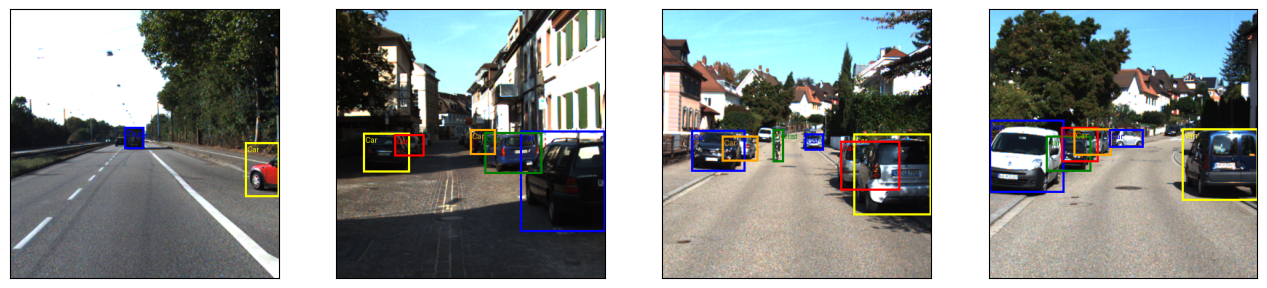

In [ ]:
display_samples_h(samples)

In [ ]:
next(iter(test_loader))

NameError: name 'test_loader' is not defined

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

device = 'cuda:0'


model.eval()
model = model.to(device)

n_samples = 0
test_loss = 0
for X, y in test_loader:
    X = X.to(device)
    y = targets_to_device(y, device)
    pred = model(X)
    loss, _  = loss_fn(pred, y)
    test_loss += loss.item()
    n_samples += len(X)

MeanAveragePrecision(box_format='cxcywh', iou_type='bbox')

In [ ]:
for i in range(9):
    